## **Google Drive Connection**

In [ ]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Paths
import os
import zipfile
import shutil

#Create the paths to deirectories
main_directory_path = "/content/drive/MyDrive/CHALLENGE 2"
models_dir = main_directory_path + "/models/"
logs_dir = main_directory_path + "/logs/"
submission_dir = main_directory_path + "/submissions/"
data_dir = main_directory_path + "/new_data/"
#backup_dir = main_directory_path + "/backup compressed/"

# Create directories if they don't exist
os.makedirs(models_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)
os.makedirs(submission_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

# Create the paths to the compresssed files
train_compressed_path_FINALE = os.path.join(data_dir, "new_train_data_compressed.npz")
test_compressed_path_FINALE = os.path.join(data_dir, "new_test_data_compressed.npz")


train_tiles_compressed_path = os.path.join(data_dir, "new_train_tiles_compressed.npz")
test_tiles_compressed_path = os.path.join(data_dir, "new_test_tiles_compressed.npz")

# Create the paths to the train labels
train_labels_path = os.path.join(data_dir, "new_train_labels.csv")
train_labels_path_FINALE = os.path.join(data_dir, "new_labels.csv")

local_train_zip = "/content/new_train_data.zip"
local_test_zip  = "/content/new_test_data.zip"

# Cartelle di estrazione locali (SSD Colab)
local_train_dir = "/content/data/new_train_data"
local_test_dir  = "/content/data/new_test_data"

os.makedirs(local_train_dir, exist_ok=True)
os.makedirs(local_test_dir, exist_ok=True)



## **Libraries Import**

In [ ]:
SEED = 42

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader

# Configurazione di TensorBoard e directory
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO

from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR

import hashlib
import re


!pip install timm -q
import timm

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

# Data saving
from datetime import datetime
data_ora_correnti = datetime.now()

data_formattata = data_ora_correnti.strftime("%Y%m%d_%H%M%S")

PyTorch version: 2.9.0+cu126
Device: cuda


# **Data Loading**

In [ ]:
# Load training and validation data as numPy vector from a compressed file (already preprocessed)
train_val = np.load(train_tiles_compressed_path)

# Separate the images from the masks in the training and validation set
train_images = train_val["images"]
train_names = train_val["names"]
train_labels = train_val["labels"]


In [ ]:
print("Train tiles:", train_images.shape)
print("Train labels:", train_labels.shape)

Train tiles: (3371, 224, 224, 3)
Train labels: (3371,)


In [ ]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(train_labels, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
1    1208
2     895
0     881
3     387
Name: count, dtype: int64


In [ ]:
# Define the input shape based on the training data
input_shape = (3, 224, 224)

# Define the number of classes based on the categorical labels
num_classes = 4

# Define the batch size
BATCH_SIZE = 16

#  **Data Preprocessing**

In [ ]:
import numpy as np

def extract_image_ids(names):
    ids = []
    for n in names:
        base = n.split("_t")[0]
        num  = int(base.replace("img_", ""))
        ids.append(num)
    return np.array(ids)

image_ids = extract_image_ids(train_names)

In [ ]:
# Augmentation and preprocessing for training set
train_augmentation = transforms.Compose([
    transforms.ToTensor(),
])

# Preprocessing for validation set
val_preprocessing = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
# @title Image-level train and validation split

# 1) LOAD NPZ WITH TILES

import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import mode


# 2) EXTRACT IMAGE IDS FROM TILE NAMES

def extract_image_ids(names):
    ids = []
    for n in names:
        base = n.split("_t")[0]
        num  = int(base.replace("img_", ""))
        ids.append(num)
    return np.array(ids)

image_ids = extract_image_ids(train_names)
print("Unique images:", len(np.unique(image_ids)))



# 3) RECONSTRUCT ORIGINAL LABEL FOR EACH IMAGE (MAJORITY VOTE)

unique_ids = np.unique(image_ids)
image_level_labels = {}

for img_id in unique_ids:
    mask = (image_ids == img_id)
    modal_class = int(mode(train_labels[mask], keepdims=True)[0][0])
    image_level_labels[img_id] = modal_class

# Convert to aligned arrays for stratification
img_ids_array = np.array(list(image_level_labels.keys()))
img_cls_array = np.array(list(image_level_labels.values()))

print("Image-level classes distribution:", np.bincount(img_cls_array))



# 4) TRAIN/VAL SPLIT — STRATIFIED ON IMAGE LEVEL

train_ids, val_ids = train_test_split(
    img_ids_array,
    test_size=0.1,
    random_state=42,
    stratify=img_cls_array
)

print("Train images:", len(train_ids))
print("Val images:", len(val_ids))



# 5) BUILD TILE MASKS FOR FINAL SPLIT — NO LEAKAGE

train_preind = np.isin(image_ids, train_ids)
val_preind   = np.isin(image_ids, val_ids)

train_indices = np.where(train_preind)[0]
val_indices   = np.where(val_preind)[0]



Unique images: 581
Image-level classes distribution: [158 204 150  69]
Train images: 522
Val images: 59


To prevent tiles from the same image from appearing in both the training and validation sets—which would result in **data leakage**—the train–validation split must be performed at the image level. Accordingly, we store the indices of the tiles associated with each image assigned to the training and validationation sets.

In [ ]:
# @title Dataset and transformations performing

class IndexedDataset(torch.utils.data.Dataset):

    def __init__(self, tiles, labels, indices, transform=None):
        self.tiles = tiles
        self.labels = labels
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]

        image = self.tiles[idx]
        label = self.labels[idx]

        # to tensor (come nel tuo dataset originale)
        image_tensor = torch.from_numpy(image).permute(2,0,1).float()

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, torch.tensor(label, dtype=torch.long)


Function to perform image transformations at the batch level, preventing RAM saturation.

In [ ]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

## **Check loader creation**

In [ ]:
train_ds = IndexedDataset(
    train_images, train_labels,
    indices=train_indices,
    transform=train_augmentation
)

val_ds = IndexedDataset(
    train_images, train_labels,
    indices=val_indices,
    transform=val_preprocessing
)

In [ ]:
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


In [ ]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


In [ ]:
for x, y in train_loader:
    print(x.shape)
    break

torch.Size([16, 3, 224, 224])


# **Model Training**

Functions for training and validation performing

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):

    # Set model to training mode
    model.train()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [ ]:
def validate_one_epoch(model, val_loader, criterion, device):

    # Set model to evaluation mode
    model.eval()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [ ]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):

    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [ ]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,scheduler=None,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0
        # Define model_save_path here so it's available for restoring weights
        model_save_path = f"{models_dir}{experiment_name}_model.pt"

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )


        # Step scheduler after validation metrics are available
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau) and evaluation_metric == "val_f1":
                scheduler.step(val_f1)
            elif isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau) and evaluation_metric == "val_loss":
                scheduler.step(val_loss)
            else:
                scheduler.step()

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                print(f"New best {evaluation_metric}: {best_metric:.4f} at epoch {best_epoch}")
                # torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
                torch.save(model.state_dict(), model_save_path)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    history_save_path = f"{models_dir}{experiment_name}_history.pt"
    os.makedirs(os.path.dirname(history_save_path), exist_ok=True)
    torch.save(training_history, history_save_path)

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model_load_path = f"{models_dir}{experiment_name}_model.pt" # Use models_dir for loading
        model.load_state_dict(torch.load(model_load_path))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), f"{models_dir}{experiment_name}_model.pt")

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

#  **Transfer Learning**

Learning the last classifier layer of the Vision Transformer with learning rate equal to $1\times10^{-4}$

In [ ]:
# @title Model class

class ViTTransfer(nn.Module):

    def __init__(self, model_name="vit_small_patch16_224", num_classes=4, dropout_rate=0.5, freeze_backbone=True):
        super().__init__()

        # Load pretrained ViT from timm
        self.backbone = timm.create_model(
            model_name,
            pretrained=True,
            num_classes=0
        )

        embed_dim = self.backbone.num_features

        # Freeze backbone
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

        # New classification head
        self.head = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):

        feats = self.backbone.forward_features(x)
        cls_token = feats[:, 0, :]
        logits = self.head(cls_token)
        return logits


In [ ]:
# @title Transfer learning augmentation cell

train_augmentation_TL = None
val_preprocessing_TL = None

In [ ]:
train_ds_TL = IndexedDataset(
    train_images, train_labels,
    indices=train_indices,
    transform=train_augmentation_TL
)

val_ds_TL = IndexedDataset(
    train_images, train_labels,
    indices=val_indices,
    transform=val_preprocessing_TL
)

In [ ]:
train_loader_TL = make_loader(train_ds_TL, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader_TL   = make_loader(val_ds_TL, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


In [ ]:
# Get one batch from the training data loader
for xb, yb in train_loader_TL:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


In [ ]:
experiment_name= "FineTunedTransformer"+ '_' + data_formattata

# Number of training epochs
LEARNING_RATE = 3e-4
EPOCHS = 200
PATIENCE = 20

# Regularisation
DROPOUT_RATE = 0.2       # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Scheduler
SCHED_NAME = 'warm'
SCHEDULER_SIZE = 0.9
SCHEDULER_WAIT = 2
COS_PERIOD = 5
ETA_MIN = 1e-6
AMPLITUDE = 0.5
MODE = 'max'




# Create transfer learning model
TL_model = ViTTransfer(num_classes=num_classes, dropout_rate=DROPOUT_RATE).to(device)

summary(TL_model, input_size=input_shape)


writer = SummaryWriter(log_dir=logs_dir)
x = torch.randn(1, input_shape[0], input_shape[1], input_shape[2]).to(device)


In [ ]:
%%time

optimizer = torch.optim.Adam(TL_model.parameters(), lr=LEARNING_RATE)

criterion = nn.CrossEntropyLoss()

scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

# Scheduler setting
if SCHED_NAME == 'plat':
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=SCHEDULER_SIZE,
        patience=SCHEDULER_WAIT,
        min_lr=1e-4
    )
elif SCHED_NAME == 'step':
  scheduler = StepLR(optimizer, step_size= SCHEDULER_WAIT, gamma=SCHEDULER_SIZE)
elif SCHED_NAME == 'cosine':
  scheduler = CosineAnnealingLR(optimizer, T_max= COS_PERIOD, eta_min=ETA_MIN)
elif SCHED_NAME == 'exp':
  scheduler = ExponentialLR(optimizer, gamma=SCHEDULER_SIZE)
elif SCHED_NAME == 'warm':
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,
    T_mult=2
)
else:
  scheduler = None


# Train with transfer learning
tl_model, tl_history = fit(
    model=TL_model,
    train_loader=train_loader_TL,
    val_loader=val_loader_TL,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scheduler = scheduler,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name=experiment_name,
    patience=PATIENCE
)

final_val_acc = round(max(tl_history['val_f1']) * 100, 2)
print(f'Final validation F1 score: {final_val_acc}%')

Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3158, F1 Score=0.3384 | Val: Loss=1.3594, F1 Score=0.2506
New best val_f1: 0.2506 at epoch 1
Epoch   2/200 | Train: Loss=1.2266, F1 Score=0.3967 | Val: Loss=1.3807, F1 Score=0.3106
New best val_f1: 0.3106 at epoch 2
Epoch   3/200 | Train: Loss=1.1806, F1 Score=0.4450 | Val: Loss=1.4086, F1 Score=0.3172
New best val_f1: 0.3172 at epoch 3
Epoch   4/200 | Train: Loss=1.1399, F1 Score=0.4799 | Val: Loss=1.4052, F1 Score=0.3023
Epoch   5/200 | Train: Loss=1.1023, F1 Score=0.5014 | Val: Loss=1.4145, F1 Score=0.2942
Epoch   6/200 | Train: Loss=1.0570, F1 Score=0.5375 | Val: Loss=1.4180, F1 Score=0.3209
New best val_f1: 0.3209 at epoch 6
Epoch   7/200 | Train: Loss=1.0312, F1 Score=0.5503 | Val: Loss=1.4263, F1 Score=0.3350
New best val_f1: 0.3350 at epoch 7
Epoch   8/200 | Train: Loss=0.9951, F1 Score=0.5885 | Val: Loss=1.4321, F1 Score=0.3302
Epoch   9/200 | Train: Loss=0.9859, F1 Score=0.5863 | Val: Loss=1.4373, F1 Score=0.3040
Epoch  10/

# **Fine-Tuning**

Adjusting the weights of the backbone with learning rate equal to $1\times10^{-5}$ and the head with learning rate equal to $3\times10^{-5}$. Differential learning rate is useful to prevent overfitting.

In [ ]:
# @title Fine-tuning augmentation cell

train_augmentation_ft = None
val_preprocessing_ft = None

In [ ]:
train_ds_ft = IndexedDataset(
    train_images, train_labels,
    indices=train_indices,
    transform=train_augmentation_ft
)

val_ds_ft = IndexedDataset(
    train_images, train_labels,
    indices=val_indices,
    transform=val_preprocessing_ft
)

In [ ]:
train_loader_ft = make_loader(train_ds_ft, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader_ft   = make_loader(val_ds_ft, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


In [ ]:
# Get one batch from the training data loader
for xb, yb in train_loader_ft:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


In [ ]:
# Setting the number of blocks to unfreeze
UNFREEZE=1

# Load the model from the previous transfer learning phase
ft_model = ViTTransfer(num_classes=num_classes, dropout_rate=DROPOUT_RATE).to(device)
ft_model.load_state_dict(torch.load(models_dir + experiment_name + "_model.pt", map_location=device))

# Freeze everything
for param in ft_model.backbone.parameters():
    param.requires_grad = False


# Unfreeze the last Transformer block
for param in ft_model.backbone.blocks[-UNFREEZE:].parameters():
    param.requires_grad = True

# Ensure the classifier head is always trainable
for param in ft_model.head.parameters():
    param.requires_grad = True


# Inspect how many parameters are trainable
total_params = sum(p.numel() for p in ft_model.parameters())
trainable_params = sum(p.numel() for p in ft_model.parameters() if p.requires_grad)


print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")


print("\nTrainable layers:")
for name, param in ft_model.named_parameters():
    if param.requires_grad:
        print(f"  {name}: {param.numel():,} parameters")

Total parameters: 21,765,252
Trainable parameters: 1,874,052
Frozen parameters: 19,891,200

Trainable layers:
  backbone.blocks.11.norm1.weight: 384 parameters
  backbone.blocks.11.norm1.bias: 384 parameters
  backbone.blocks.11.attn.qkv.weight: 442,368 parameters
  backbone.blocks.11.attn.qkv.bias: 1,152 parameters
  backbone.blocks.11.attn.proj.weight: 147,456 parameters
  backbone.blocks.11.attn.proj.bias: 384 parameters
  backbone.blocks.11.norm2.weight: 384 parameters
  backbone.blocks.11.norm2.bias: 384 parameters
  backbone.blocks.11.mlp.fc1.weight: 589,824 parameters
  backbone.blocks.11.mlp.fc1.bias: 1,536 parameters
  backbone.blocks.11.mlp.fc2.weight: 589,824 parameters
  backbone.blocks.11.mlp.fc2.bias: 384 parameters
  head.0.weight: 98,304 parameters
  head.0.bias: 256 parameters
  head.3.weight: 1,024 parameters
  head.3.bias: 4 parameters


In [ ]:
%%time

# Setting differential learning rates
lr_backbone = 1e-5
lr_head     = 3e-5

optimizer = torch.optim.AdamW([
    {"params": ft_model.backbone.blocks[-UNFREEZE:].parameters(), "lr": lr_backbone},
    {"params": ft_model.head.parameters(), "lr": lr_head},
], weight_decay=1e-4)


# Fine-tune the model
ft_model, training_history = fit(
    model=ft_model,
    train_loader=train_loader_ft,
    val_loader=val_loader_ft,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler = scheduler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name=experiment_name,
    patience=PATIENCE
)

final_val_acc = round(max(training_history['val_f1']) * 100, 2)
print(f'Final validation accuracy: {final_val_acc}%')

Training 200 epochs...
Epoch   1/200 | Train: Loss=0.5574, F1 Score=0.8239 | Val: Loss=1.7074, F1 Score=0.3471
New best val_f1: 0.3471 at epoch 1
Epoch   2/200 | Train: Loss=0.5309, F1 Score=0.8316 | Val: Loss=1.7372, F1 Score=0.3286
Epoch   3/200 | Train: Loss=0.5170, F1 Score=0.8356 | Val: Loss=1.8085, F1 Score=0.3201
Epoch   4/200 | Train: Loss=0.4905, F1 Score=0.8460 | Val: Loss=1.7943, F1 Score=0.3198
Epoch   5/200 | Train: Loss=0.4777, F1 Score=0.8535 | Val: Loss=1.8144, F1 Score=0.3195
Epoch   6/200 | Train: Loss=0.4525, F1 Score=0.8637 | Val: Loss=1.8552, F1 Score=0.3265
Epoch   7/200 | Train: Loss=0.4396, F1 Score=0.8643 | Val: Loss=1.8898, F1 Score=0.3169
Epoch   8/200 | Train: Loss=0.4193, F1 Score=0.8795 | Val: Loss=1.8815, F1 Score=0.3207
Epoch   9/200 | Train: Loss=0.4192, F1 Score=0.8750 | Val: Loss=1.8856, F1 Score=0.3356
Epoch  10/200 | Train: Loss=0.4002, F1 Score=0.8783 | Val: Loss=1.9137, F1 Score=0.3332
Epoch  11/200 | Train: Loss=0.3849, F1 Score=0.8865 | Val: Los

## **Plot History**

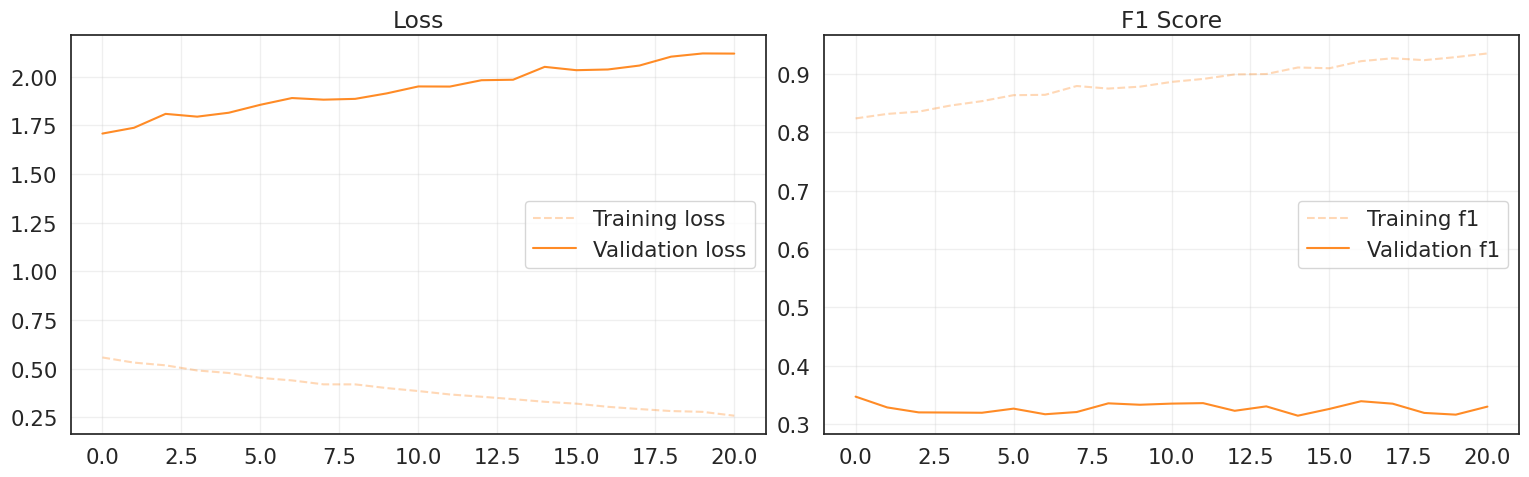

In [ ]:
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

## **Plot Confusion Matrix**

Accuracy over the validation set: 0.3497
Precision over the validation set: 0.3460
Recall over the validation set: 0.3497
F1 score over the validation set: 0.3471


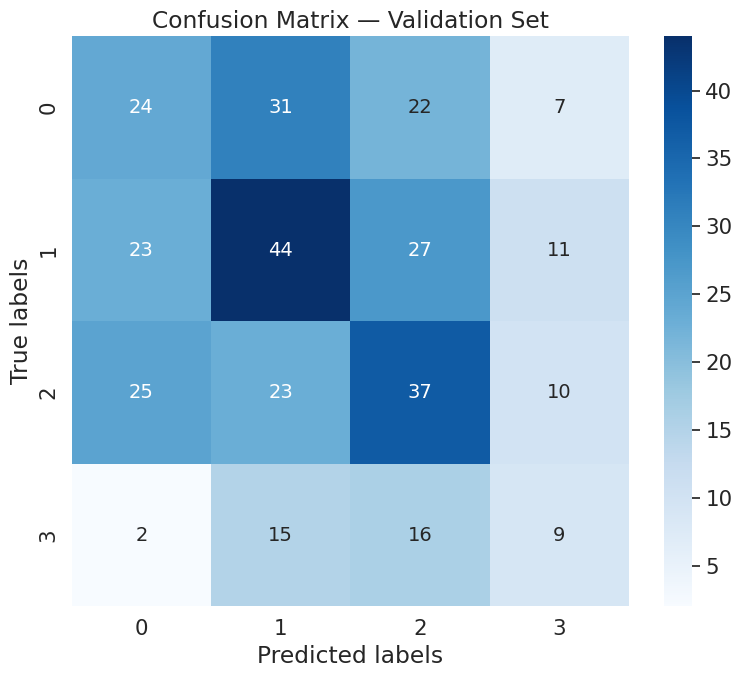

In [ ]:
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader_ft:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = ft_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

The confusion matrix indicates that the **Triple Negative** class—being the minority class—is particularly challenging to predict. In addition, the model exhibits difficulty in distinguishing among the **Luminal A**, **Luminal B**, and **HER2(+)** classes. However, we can see that it is able to efficiently capture the overall distribution of the classes.

# **Inference**

In [ ]:
# Remove training images from memory to prevent RAM saturation
import gc

del train_images
gc.collect()
torch.cuda.empty_cache()


In [ ]:
# @title Load .npz with Tiles

# LOAD TEST DATA
test = np.load(test_tiles_compressed_path)

test_images  = test["images"]
test_names   = test["names"]
test_weights = test["weights"]

print(test_images.shape, test_weights.shape)

# Chosing to use mask-weighted soft voting or not
WEIGHTED = False

(2707, 224, 224, 3) (2707,)


In [ ]:
import torch
from torchvision import transforms


test_preprocessing = None

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]

        img_tensor = torch.from_numpy(img).permute(2, 0, 1).float()

        if self.transform:
            img_tensor = self.transform(img_tensor)
        return img_tensor, idx


In [ ]:
test_ds = TestDataset(test_images, transform=test_preprocessing)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [ ]:
ft_model.eval()
test_predictions = []

with torch.no_grad():
    for imgs, idxs in test_loader:
        imgs = imgs.to(torch.float32).to(device)
        logits = ft_model(imgs)
        preds = logits.argmax(dim=1).cpu().numpy()
        test_predictions.append(preds)

test_predictions = np.concatenate(test_predictions)


In [ ]:
# @title Mask-weighted soft voting

from collections import defaultdict

def tile_voting_weighted(names, predictions, weights):
    groups = defaultdict(list)

    for name, pred, w in zip(names, predictions, weights):
        base = name.split("_t")[0]
        groups[base].append((pred, w))

    final_preds = {}

    for img_name, items in groups.items():
        class_scores = defaultdict(float)

        for pred, w in items:
            class_scores[pred] += w

        winner = max(class_scores, key=class_scores.get)
        final_preds[img_name] = int(winner)

    return final_preds


In [ ]:
# @title Hard voting

from collections import defaultdict
from scipy.stats import mode
import numpy as np

def tile_voting_mode(names, predictions):
    groups = defaultdict(list)

    for name, pred in zip(names, predictions):
        base = name.split("_t")[0]
        groups[base].append(pred)

    final_preds = {}

    for img_name, preds in groups.items():
        preds = np.array(preds)
        winner = mode(preds, keepdims=True)[0][0]
        final_preds[img_name] = int(winner)

    return final_preds


In [ ]:
# Performing voting

if WEIGHTED:
  print("Using weighted voting")
  final_predictions = tile_voting_weighted(
      test_names,
      test_predictions,
      test_weights
  )
else:
  print("Using mode voting")
  final_predictions = tile_voting_mode(
      test_names,
      test_predictions
  )

for img, pred in final_predictions.items():
    print(img, "→ predicted class:", pred)


Using mode voting
img_0000 → predicted class: 0
img_0001 → predicted class: 1
img_0002 → predicted class: 0
img_0003 → predicted class: 1
img_0004 → predicted class: 0
img_0005 → predicted class: 2
img_0006 → predicted class: 1
img_0007 → predicted class: 0
img_0008 → predicted class: 0
img_0009 → predicted class: 1
img_0010 → predicted class: 1
img_0011 → predicted class: 1
img_0012 → predicted class: 0
img_0013 → predicted class: 2
img_0014 → predicted class: 1
img_0015 → predicted class: 2
img_0016 → predicted class: 1
img_0017 → predicted class: 1
img_0018 → predicted class: 1
img_0019 → predicted class: 2
img_0020 → predicted class: 2
img_0021 → predicted class: 1
img_0022 → predicted class: 1
img_0023 → predicted class: 0
img_0024 → predicted class: 1
img_0025 → predicted class: 0
img_0026 → predicted class: 0
img_0027 → predicted class: 0
img_0028 → predicted class: 2
img_0029 → predicted class: 1
img_0030 → predicted class: 1
img_0031 → predicted class: 0
img_0032 → predicted c

In [ ]:
# Labels dictionary
labels = {
    0: 'Luminal A',
    1: 'Luminal B',
    2: 'HER2(+)',
    3: 'Triple negative',
}

# Convert dict → sorted list
sorted_items = sorted(final_predictions.items(), key=lambda x: x[0])

sample_index = [f"{name}.png" for name, pred in sorted_items]
pred_classes = [pred for name, pred in sorted_items]
pred_labels  = [labels[int(c)] for c in pred_classes]

submission_df = pd.DataFrame({
    "sample_index": sample_index,
    "label": pred_labels
})

display(submission_df.head())
print(submission_df["label"].value_counts())


,sample_index,label
0,img_0000.png,Luminal A
1,img_0001.png,Luminal B
2,img_0002.png,Luminal A
3,img_0003.png,Luminal B
4,img_0004.png,Luminal A


label
Luminal B          198
HER2(+)            140
Luminal A          118
Triple negative     21
Name: count, dtype: int64


In [ ]:
# Save the submission DataFrame to a CSV file with the specified format

submission_df.to_csv(submission_dir+f'submission_'+experiment_name+'.csv', index=False)
print("Submission file updated with the correct format and saved successfully!")

Submission file updated with the correct format and saved successfully!
